## Reproduction of Table 4

This notebook reproduces the values in Table 4 (project-specific reproduction performance). 

In [1]:
import sys
import json
import pandas

In [2]:
with open('../data/etc/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

In [3]:
def evaluate(raw_result, only_crash=False):
    rows = []
    
    for bug_id, test_exec_results in raw_result.items():
        if bug_id in invalid_bugs:
            continue
        if only_crash and bug_id not in jcrashpack_bugs:
            continue
            
        for i, (fname, res) in enumerate(test_exec_results.items()):
            javalang_parse_error = False
            is_compile_error = False
            is_runtime_error = False
            buggy_version_failing = False
            fixed_version_failing = False
            success = False

            if isinstance(res, str):
                javalang_parse_error = True 
            elif res['buggy']['compile_error']:
                is_compile_error = True
            elif res['buggy']['runtime_error']:
                is_runtime_error = True
            else:
                if res['buggy']['autogen_failed']:
                    buggy_version_failing = True
                if res['fixed'] is not None and res['fixed']['autogen_failed']:
                    fixed_version_failing = True
                if buggy_version_failing and (not fixed_version_failing):
                    success = True
            
            rows.append({
                'project': '-'.join(bug_id.split('_')[:-1]),
                'bug_id': bug_id,
                'test_no': i+1,
                'javalang_parse_error': javalang_parse_error,
                'is_compile_error': is_compile_error,
                'is_runtime_error': is_runtime_error,
                'buggy_version_failing': buggy_version_failing,
                'fixed_version_failing': fixed_version_failing,
                'fname': fname,
                'success': success,
            })
    
    return pandas.DataFrame(rows)

In [4]:
RESULT_PATH = '../data/exec_results/example2_n50.json'
# RESULT_PATH_GHRB = '../data/exec_results/starcoder_n50_ghrb.json'
# RESULT_PATH_GHRB = '../data/exec_results/example2_n50_GHRB.json'
# RESULT_PATH_GHRB = '../data/exec_results/gpt-3.5-turbo_n50_ghrb.json'
result_path = {
    'code-davinci-002': '../data/exec_results/example2_n50_GHRB.json',
    'gpt-3.5-turbo': '../data/exec_results/gpt-3.5-turbo_n50_ghrb.json',
    'StarCoder-15B': '../data/exec_results/starcoder_n50_ghrb.json',
    'StarCoderBase-15B': '../data/exec_results/starcoderbase_ghrb.json',
    'CodeGen2-16B': '../data/exec_results/CodeGen2-16B_ghrb.json',
    # 'StarCoderBase': '../data/exec_results/d4j_StarCoderBase.json',
    # 'CodeGen2-16B': '../data/exec_results/d4j_CodeGen2-16B.json',
}

In [7]:
from collections import defaultdict 

tab_results = []

project2totalnum = defaultdict(list)

for name, path in result_path.items():
    RESULT_PATH_GHRB = path
    with open(RESULT_PATH_GHRB) as f:
        reproduction_df = evaluate(json.load(f))

    aggr_eval_df = reproduction_df.groupby('bug_id').sum().reset_index()
    if name == 'Codex':
        aggr_eval_df['project'] = aggr_eval_df.bug_id.apply(lambda x: '-'.join(x.split('-')[:-1]))
    else:
        aggr_eval_df['project'] = aggr_eval_df.bug_id.apply(lambda x: '_'.join(x.split('_')[:-1]))
    succeeded_bugs = aggr_eval_df[aggr_eval_df.success > 0]


    total_succ = 0
    total_bugs = 0
    model_result = {'Model': name}
    for project in sorted(set(aggr_eval_df.project.tolist())):
        succeeded_bug_ids = succeeded_bugs[succeeded_bugs.project == project].bug_id.tolist()
        succ_num = len(succeeded_bug_ids)
        total_succ += succ_num
        total_num = (aggr_eval_df.project == project).sum()
        total_bugs += total_num
        model_result[project] = succ_num
        project2totalnum[project].append(total_num)
    
    model_result['Total'] = str(total_succ)
    
    tab_results.append(model_result)

tab_results.append({'Model': '# Bugs', **{k: max(v) for k, v in project2totalnum.items()}, 'Total': sum([max(v) for v in project2totalnum.values()])})
tab_df = pandas.DataFrame(tab_results)
print(project2totalnum)
tab_df.set_index('Model').T

defaultdict(<class 'list'>, {'FasterXML': [2], 'Hakky54': [2], 'assertj': [5], 'checkstyle': [13], 'google': [7], 'jhy': [2], 'FasterXML_jackson-databind': [2, 2, 2, 2], 'Hakky54_sslcontext-kickstart': [2, 2, 2, 1], 'assertj_assertj-core': [5, 5, 5, 4], 'checkstyle_checkstyle': [12, 12, 12, 9], 'google_gson': [7, 7, 7, 6], 'jhy_jsoup': [2, 2, 2, 2]})


Model,code-davinci-002,gpt-3.5-turbo,StarCoder-15B,StarCoderBase-15B,CodeGen2-16B,# Bugs
FasterXML,0.0,NaN,NaN,NaN,NaN,2.0
Hakky54,1.0,NaN,NaN,NaN,NaN,2.0
assertj,3.0,NaN,NaN,NaN,NaN,5.0
checkstyle,0.0,NaN,NaN,NaN,NaN,13.0
google,4.0,NaN,NaN,NaN,NaN,7.0
jhy,2.0,NaN,NaN,NaN,NaN,2.0
Total,10,3,9,7,1,61
FasterXML_jackson-databind,NaN,0.0,1.0,1.0,0.0,2.0
Hakky54_sslcontext-kickstart,NaN,0.0,1.0,1.0,0.0,2.0
assertj_assertj-core,NaN,0.0,0.0,0.0,0.0,5.0


In [10]:
df = tab_df.set_index('Model').T
print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
Model & code-davinci-002 & gpt-3.5-turbo & StarCoder-15B & StarCoderBase-15B & CodeGen2-16B & # Bugs \\
\midrule
FasterXML & 0.000000 & NaN & NaN & NaN & NaN & 2.000000 \\
Hakky54 & 1.000000 & NaN & NaN & NaN & NaN & 2.000000 \\
assertj & 3.000000 & NaN & NaN & NaN & NaN & 5.000000 \\
checkstyle & 0.000000 & NaN & NaN & NaN & NaN & 13.000000 \\
google & 4.000000 & NaN & NaN & NaN & NaN & 7.000000 \\
jhy & 2.000000 & NaN & NaN & NaN & NaN & 2.000000 \\
Total & 10 & 3 & 9 & 7 & 1 & 61 \\
FasterXML_jackson-databind & NaN & 0.000000 & 1.000000 & 1.000000 & 0.000000 & 2.000000 \\
Hakky54_sslcontext-kickstart & NaN & 0.000000 & 1.000000 & 1.000000 & 0.000000 & 2.000000 \\
assertj_assertj-core & NaN & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 5.000000 \\
checkstyle_checkstyle & NaN & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 12.000000 \\
google_gson & NaN & 2.000000 & 5.000000 & 3.000000 & 1.000000 & 7.000000 \\
jhy_jsoup & NaN & 1.000000 & 2.000000 & 2.0

In [12]:
# boxplot - sample N tests randomly and plot the success rate
import random 
from tqdm import tqdm

random.seed(0)

N = 10
n_samples = 1000

sampled_result = []

project2totalnum = defaultdict(list)

for name, path in tqdm(result_path.items()):
    RESULT_PATH_GHRB = path
    with open(RESULT_PATH_GHRB) as f:
        reproduction_df = evaluate(json.load(f))

    if name == 'Codex':
        reproduction_df['project'] = reproduction_df.bug_id.apply(lambda x: '-'.join(x.split('-')[:-1]))
    else:
        reproduction_df['project'] = reproduction_df.bug_id.apply(lambda x: '_'.join(x.split('_')[:-1]))

    for i in range(n_samples):
        success_count = 0
        for bug_id in reproduction_df.bug_id.unique().tolist():
            if reproduction_df[reproduction_df.bug_id == bug_id].sample(N).success.max() > 0:
                success_count += 1

        sampled_result.append({
            'Model': name,
            'sample_no': i+1,
            'num_reproduced': success_count,
        })

sampled_df = pandas.DataFrame(sampled_result)
sampled_df.head()

100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


,Model,sample_no,num_reproduced
0,code-davinci-002,1,6
1,code-davinci-002,2,6
2,code-davinci-002,3,5
3,code-davinci-002,4,5
4,code-davinci-002,5,5


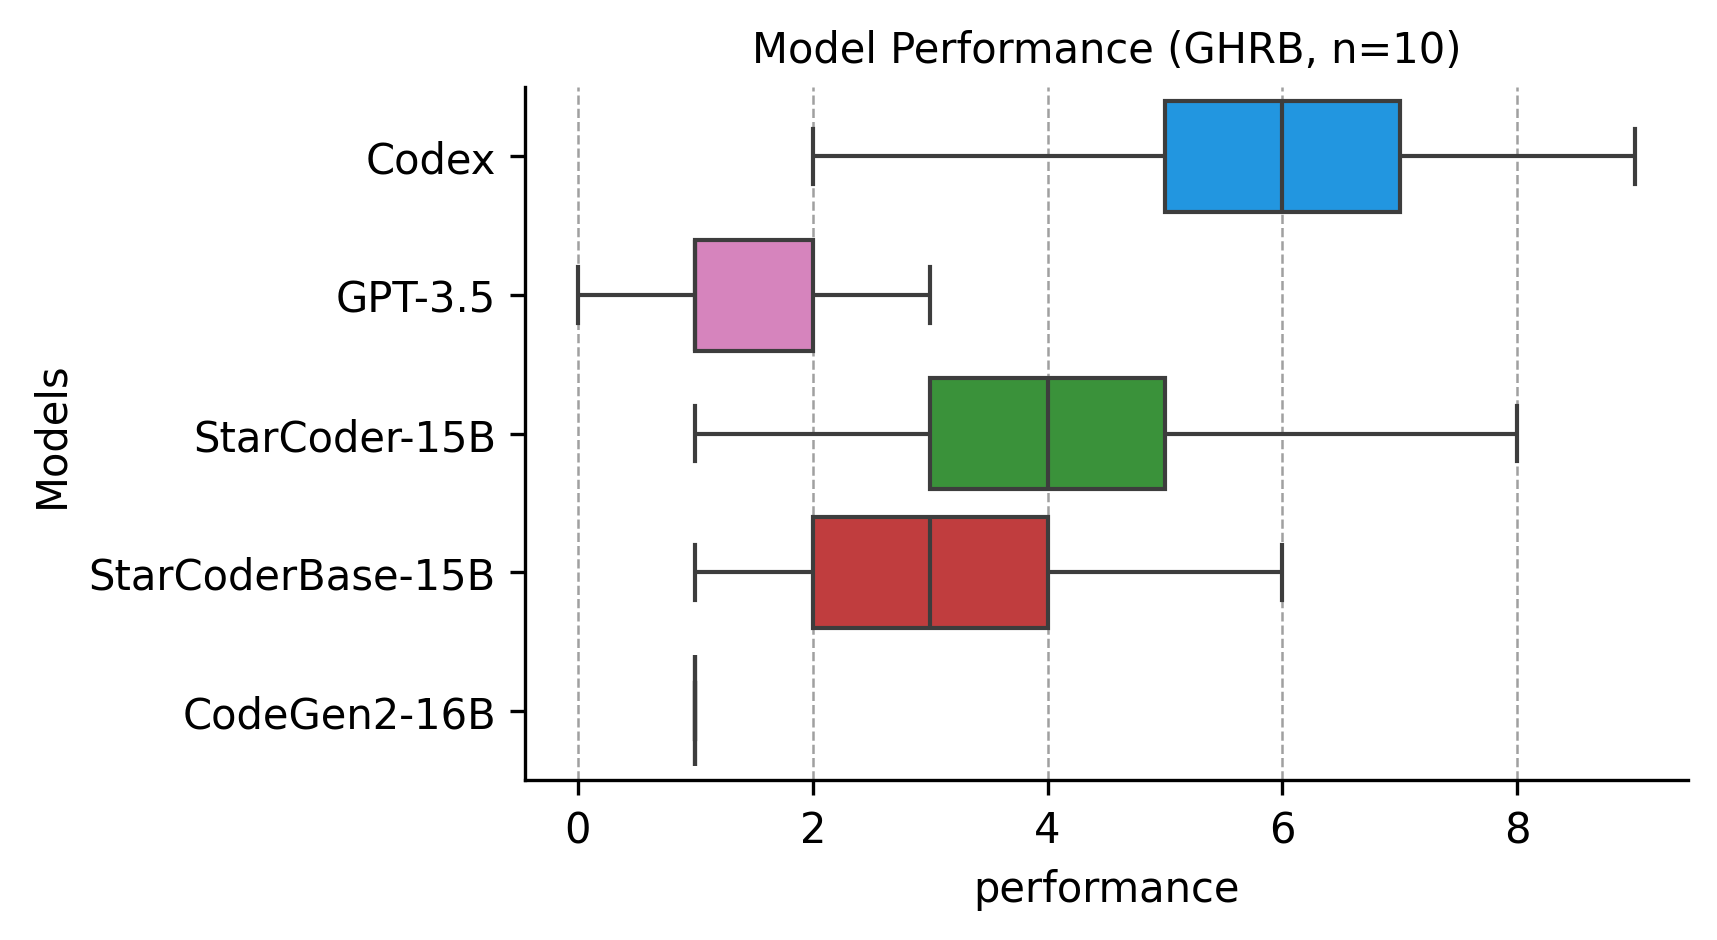

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('./smstyle-formal.mplstyle')

sampled_df.rename(columns={'num_reproduced': 'performance', 'Model': 'Models'}, inplace=True)
# rename models 
sampled_df.Models = sampled_df.Models.apply(lambda x: x.replace('code-davinci-002', 'Codex'))
sampled_df.Models = sampled_df.Models.apply(lambda x: x.replace('gpt-3.5-turbo', 'GPT-3.5'))

plt.figure(figsize=(5, 3))
sns.boxplot(data=sampled_df, y='Models', x='performance', hue='Models')
plt.title('Model Performance (GHRB, n=10)', fontdict={'fontsize': 10})
plt.savefig('../data/figures/model_performance_boxplot_ghrb.pdf', bbox_inches='tight')